In [2]:
train_dir = 'asl_alphabet_train'
val_dir = 'asl_alphabet_val'
IMG_SIZE = 200,200

In [3]:
!ls asl_alphabet_train

A  C  del  F  H  J  L  N	O  Q  S      T	V  X  Z
B  D  E    G  I  K  M  nothing	P  R  space  U	W  Y


In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import keras
from keras import regularizers
import cv2
import matplotlib.pyplot as plt
import glob
from keras.layers import *

2023-02-19 11:14:28.573888: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(   
    directory=train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    seed=40,
    batch_size=256
)

val_data = tf.keras.preprocessing.image_dataset_from_directory( 
    directory=val_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    seed=40,
    batch_size=256
)

Found 10326 files belonging to 29 classes.
Found 4526 files belonging to 29 classes.


2023-02-19 11:14:30.063863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 11:14:30.082414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 11:14:30.082537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 11:14:30.082877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [6]:
input_shape = (200, 200, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

# Tạo layer đầu vào
inputs = Input(shape=input_shape, name="input_layer")

# Thêm vào mô hình tuần tự tăng cường dữ liệu dưới dạng layer
# x = data_augmentation(inputs)

# Cung cấp đầu vào cho base_model (sau khi tăng cường) và không huấn luyện nó 
x = base_model(inputs, training=False)

# Gộp các đặc trưng đầu ra của base model
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

# x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
#                 bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x = Dense(256)(x)
x = Dropout(rate=.4)(x)  

# Đặt dense layer làm đầu ra
outputs = Dense(29, activation="softmax", name="output_layer")(x)

# Tạo mô hình với đầu vào và đầu ra
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 200, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 output_layer (Dense)        (None, 29)                7453      
                                                             

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.005),loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=8, verbose=1)

filepath="best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [early_stopping, checkpoint]

In [8]:
model_hist = model.fit(train_data,validation_data = val_data, epochs = 60, callbacks=callbacks_list)

Epoch 1/60


2023-02-19 10:18:05.327265: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


41/41 [==============================] - ETA: 0s - loss: 0.8899 - accuracy: 0.7604
Epoch 1: val_accuracy improved from -inf to 0.99713, saving model to best_model.h5
41/41 [==============================] - 21s 413ms/step - loss: 0.8899 - accuracy: 0.7604 - val_loss: 0.0194 - val_accuracy: 0.9971
Epoch 2/60
41/41 [==============================] - ETA: 0s - loss: 0.1425 - accuracy: 0.9543
Epoch 2: val_accuracy improved from 0.99713 to 0.99978, saving model to best_model.h5
41/41 [==============================] - 15s 377ms/step - loss: 0.1425 - accuracy: 0.9543 - val_loss: 0.0083 - val_accuracy: 0.9998
Epoch 3/60
41/41 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9733
Epoch 3: val_accuracy did not improve from 0.99978
41/41 [==============================] - 15s 374ms/step - loss: 0.0867 - accuracy: 0.9733 - val_loss: 0.0053 - val_accuracy: 0.9998
Epoch 4/60
41/41 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9841
Epoch 4: val_accura

In [9]:
model.save('model.h5')

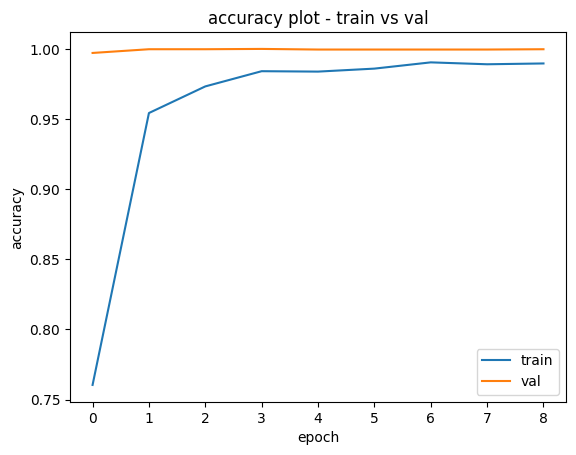

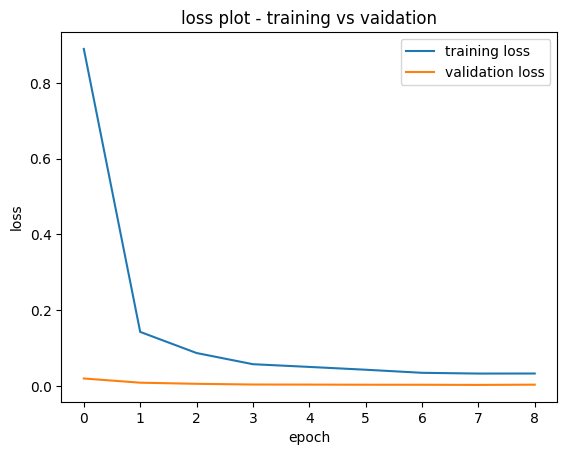

In [11]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.legend(['train', 'val'], loc='lower right')
plt.title('accuracy plot - train vs val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [9]:
model = keras.models.load_model('best_model.h5')

In [10]:
evaluate_metrics = model.evaluate(val_data)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(evaluate_metrics[0]))

2023-02-19 11:14:56.986227: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


18/18 [==============================] - 7s 275ms/step - loss: 0.0035 - accuracy: 1.0000

Evaluation Accuracy =  100.00% 
Evaluation loss =  0.003451


In [11]:
labels = []
predicts = []
for image, label in val_data.unbatch():
    predict = np.argmax(np.squeeze(model.predict(image.numpy().reshape(1,200,200,3))))
    predicts.append(predict)
    labels.append(np.argmax(label))

predicts = np.array(predicts)
labels = np.array(labels)

1/1 [==============================] - 0s 14ms/step


Confusion matrix, without normalization


<Figure size 2000x2000 with 0 Axes>

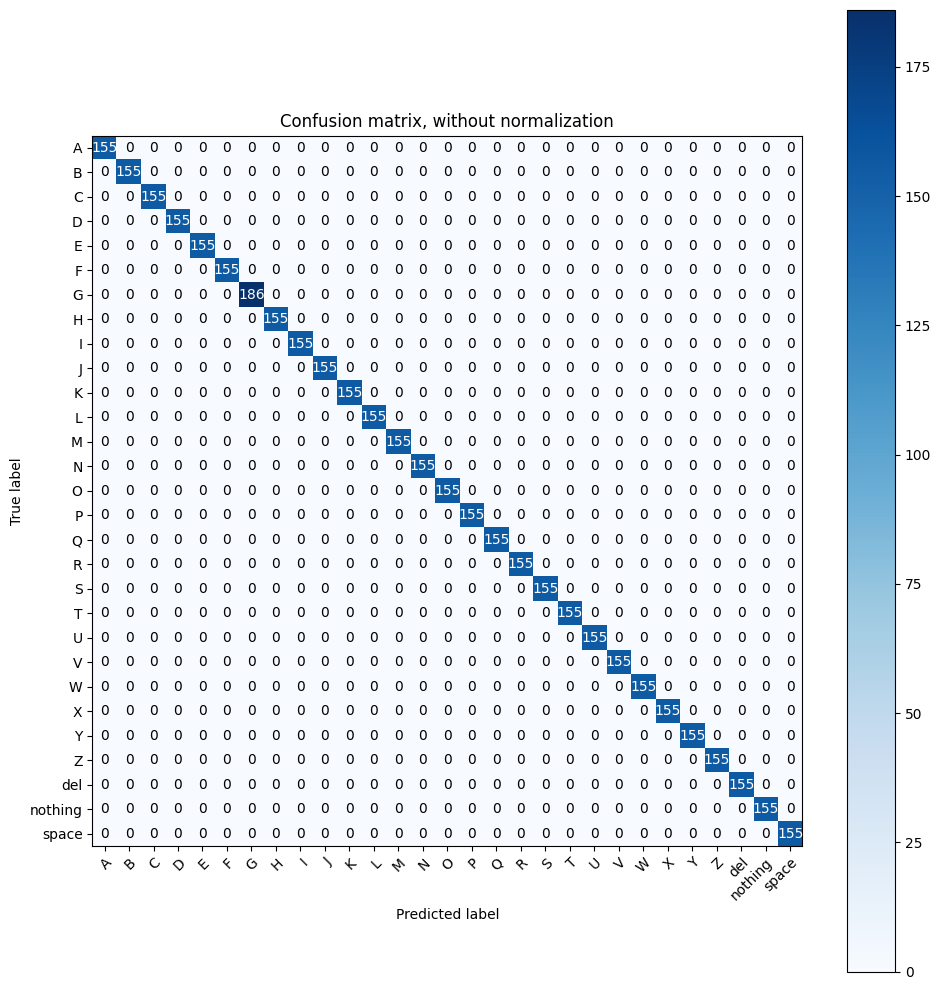

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = metrics.confusion_matrix(labels, predicts)
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Visualizing
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

#Non-Normalized Confusion Matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(labels, predicts, classes = train_data.class_names)
plt.show()

In [13]:
from sklearn.metrics import classification_report
print(classification_report(labels, predicts))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00       155
           2       1.00      1.00      1.00       155
           3       1.00      1.00      1.00       155
           4       1.00      1.00      1.00       155
           5       1.00      1.00      1.00       155
           6       1.00      1.00      1.00       186
           7       1.00      1.00      1.00       155
           8       1.00      1.00      1.00       155
           9       1.00      1.00      1.00       155
          10       1.00      1.00      1.00       155
          11       1.00      1.00      1.00       155
          12       1.00      1.00      1.00       155
          13       1.00      1.00      1.00       155
          14       1.00      1.00      1.00       155
          15       1.00      1.00      1.00       155
          16       1.00      1.00      1.00       155
          17       1.00    

: 